In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)
print(len(data))

26709


In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [6]:
training_size = 20000
vocab_size = 20000
maxlen = 50
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, maxlen=maxlen, padding='post', truncating='post')
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, maxlen=maxlen, padding='post', truncating='post')

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [9]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(input_dim=20000, output_dim=32),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, maxlen))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 32)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,817 (2.44 MB)

 Trainable params: 640,817 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5663 - loss: 0.6818 - val_accuracy: 0.7332 - val_loss: 0.6217
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7410 - loss: 0.5457 - val_accuracy: 0.7441 - val_loss: 0.5012
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8462 - loss: 0.3596 - val_accuracy: 0.7798 - val_loss: 0.4586
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8885 - loss: 0.2784 - val_accuracy: 0.7863 - val_loss: 0.4760
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9139 - loss: 0.2260 - val_accuracy: 0.8050 - val_loss: 0.4487
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9319 - loss: 0.1851 - val_accuracy: 0.7810 - val_loss: 0.5226
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9337 - loss: 0.1709 - val_accuracy: 0.7994 - val_loss: 0.5040
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9437 - loss: 0.1498 - val_accuracy: 0.

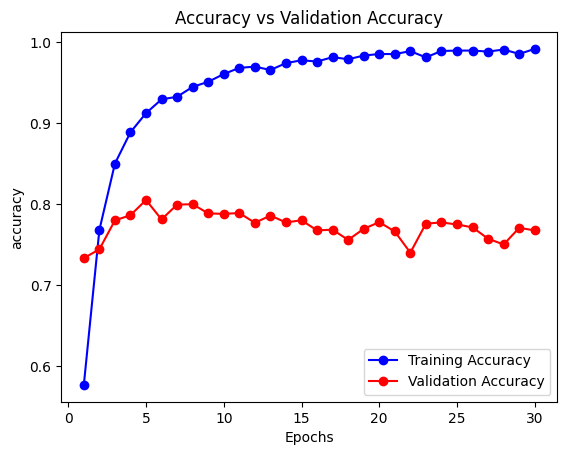

In [11]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

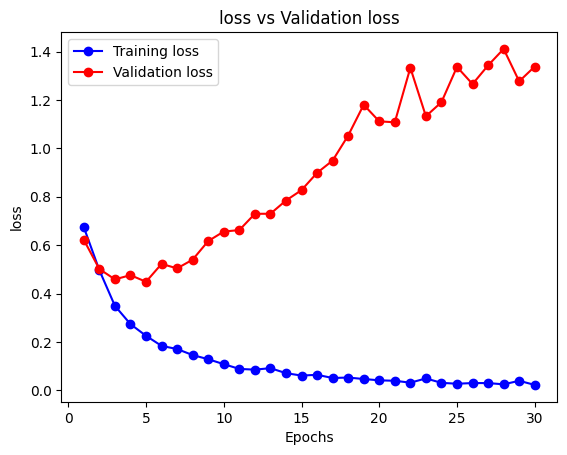

In [12]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [13]:
## Adjusting the learning rate
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001,beta_1=0.95, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history1 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9979 - loss: 0.0078 - val_accuracy: 0.7733 - val_loss: 1.3400
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9983 - loss: 0.0077 - val_accuracy: 0.7719 - val_loss: 1.3420
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9986 - loss: 0.0070 - val_accuracy: 0.7706 - val_loss: 1.3437
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9984 - loss: 0.0073 - val_accuracy: 0.7669 - val_loss: 1.3465
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9985 - loss: 0.0067 - val_accuracy: 0.7676 - val_loss: 1.3494
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9988 - loss: 0.0069 - val_accuracy: 0.7675 - val_loss: 1.3530
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9983 - loss: 0.0068 - val_accuracy: 0.7705 - val_loss: 1.3552
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9982 - loss: 0.0070 - val_accuracy: 0.

In [14]:
## Exploring embedding dimensions
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(25000, 16),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.95, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

history2 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5556 - loss: 0.6867 - val_accuracy: 0.5633 - val_loss: 0.6832
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5578 - loss: 0.6841 - val_accuracy: 0.5633 - val_loss: 0.6819
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5584 - loss: 0.6825 - val_accuracy: 0.5633 - val_loss: 0.6801
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5562 - loss: 0.6802 - val_accuracy: 0.5633 - val_loss: 0.6773
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5609 - loss: 0.6745 - val_accuracy: 0.5633 - val_loss: 0.6708
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5677 - loss: 0.6649 - val_accuracy: 0.5700 - val_loss: 0.6618
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5836 - loss: 0.6545 - val_accuracy: 0.5984 - val_loss: 0.6484
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6177 - loss: 0.6374 - val_accuracy: 0.

In [15]:
## Using Dropout
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(20000, 16),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dropout(.25),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.95, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

history3 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5492 - loss: 0.6901 - val_accuracy: 0.5633 - val_loss: 0.6848
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5596 - loss: 0.6857 - val_accuracy: 0.5633 - val_loss: 0.6835
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5601 - loss: 0.6842 - val_accuracy: 0.5633 - val_loss: 0.6827
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5591 - loss: 0.6836 - val_accuracy: 0.5633 - val_loss: 0.6818
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5532 - loss: 0.6832 - val_accuracy: 0.5633 - val_loss: 0.6805
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5608 - loss: 0.6798 - val_accuracy: 0.5633 - val_loss: 0.6784
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5576 - loss: 0.6790 - val_accuracy: 0.5633 - val_loss: 0.6759
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5545 - loss: 0.6765 - val_accuracy: 0.

In [16]:
## Using regularization
model = tf.keras.Sequential([
            tf.keras.layers.Embedding(20000, 16),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(.25),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001,beta_1=0.95, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )
history4 = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5584 - loss: 0.7851 - val_accuracy: 0.5633 - val_loss: 0.7585
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5567 - loss: 0.7544 - val_accuracy: 0.5633 - val_loss: 0.7345
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5569 - loss: 0.7316 - val_accuracy: 0.5633 - val_loss: 0.7173
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5578 - loss: 0.7150 - val_accuracy: 0.5633 - val_loss: 0.7053
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5575 - loss: 0.7039 - val_accuracy: 0.5633 - val_loss: 0.6971
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5580 - loss: 0.6966 - val_accuracy: 0.5633 - val_loss: 0.6913
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5586 - loss: 0.6915 - val_accuracy: 0.5633 - val_loss: 0.6877
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5583 - loss: 0.6875 - val_accuracy: 0.

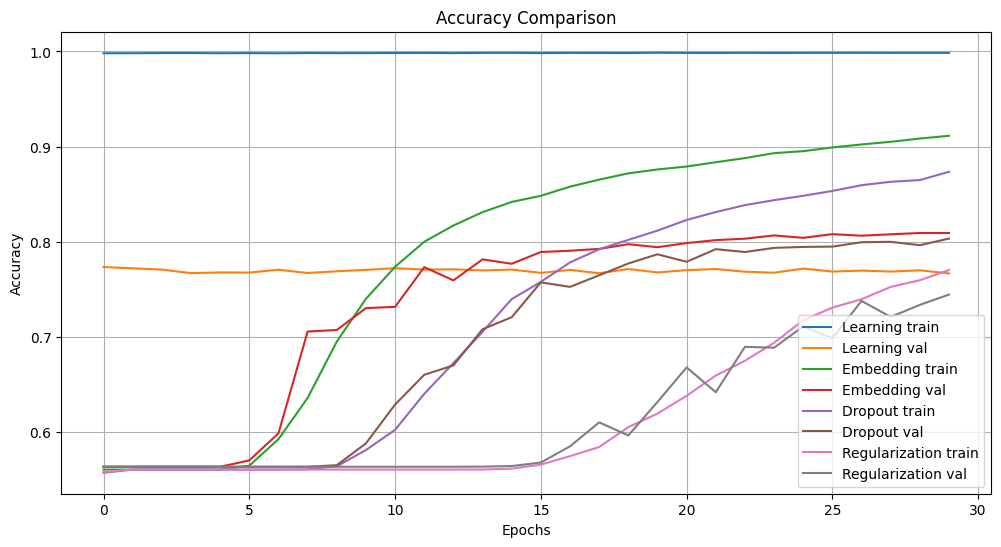

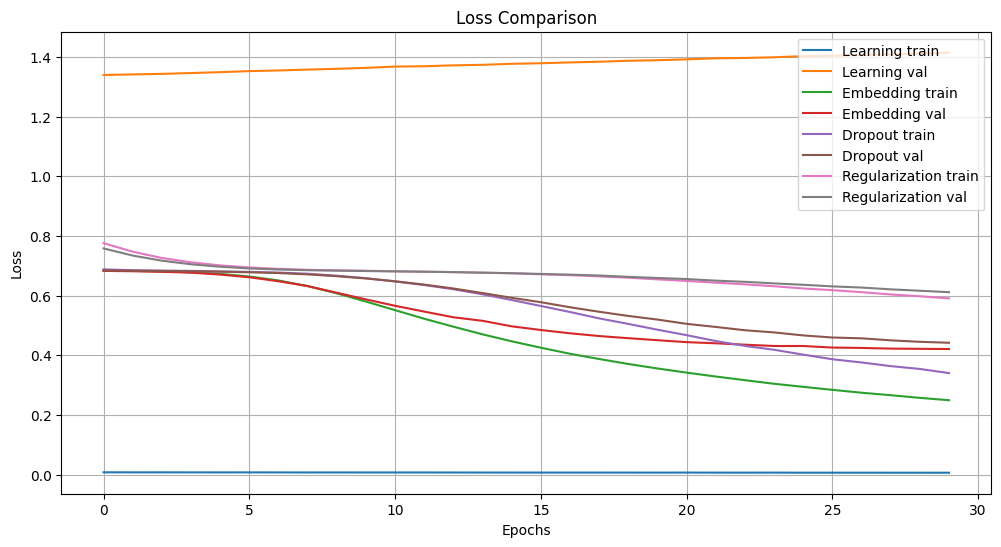

In [17]:
def plot_history(histories, metric='accuracy'):
    plt.figure(figsize=(12, 6))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} train')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} val')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(f'{metric.capitalize()} Comparison')
    plt.grid(True)
    plt.show()

histories = {
    'Learning': history1,
    'Embedding': history2,
    'Dropout': history3,
    'Regularization': history4
}
plot_history(histories, 'accuracy')
plot_history(histories, 'loss')


## Making Prediction

In [18]:
sarcastic_sentences = [
    "Oh great, another Monday morning. Just what I needed.",
    "I absolutely love when my phone dies in the middle of an important call.",
    "Sure, I’d love to work overtime this weekend—for free.",
    "Because nothing screams fun like standing in line at the DMV.",
    "Of course the printer stops working right before the deadline.",
    "Wow, my internet just got slower—what a dream come true.",
    "Yay, traffic again! I was hoping I'd spend an hour going five miles.",
    "I totally didn't need sleep last night, thanks for asking.",
    "Love when the coffee machine breaks down at 8 a.m.",
    "Oh fantastic, spilled coffee on my shirt right before the meeting."
]

In [24]:
sequences1 = tokenizer.texts_to_sequences(sarcastic_sentences)
padded1 = pad_sequences(sequences1, maxlen=maxlen, padding="post", truncating="post")
print(model.predict(padded1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.49927434]
 [0.6240811 ]
 [0.55350995]
 [0.6322088 ]
 [0.5964168 ]
 [0.5424335 ]
 [0.6493771 ]
 [0.4919247 ]
 [0.6153949 ]
 [0.6313056 ]]


In [25]:
non_sarcastic_sentences = [
    "The sky was clear and the weather was perfect for a walk.",
    "She enjoys reading historical fiction in her free time.",
    "He just started a new job as a software engineer.",
    "Granny baked cookies for the whole family.",
    "They are planning a trip to the mountains this winter.",
    "The team celebrated their victory with a party.",
    "The new restaurant downtown serves delicious sushi.",
    "I finally finished my TensorFlow project last night.",
    "They planted tomatoes and peppers in the garden.",
    "The dog wagged its tail when I came home."
]

In [26]:
sequences2 = tokenizer.texts_to_sequences(non_sarcastic_sentences)
padded2 = pad_sequences(sequences2, maxlen=maxlen, padding="post", truncating="post")
print(model.predict(padded2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.62306756]
 [0.62641585]
 [0.63826185]
 [0.5673172 ]
 [0.6150601 ]
 [0.54277205]
 [0.51627773]
 [0.620238  ]
 [0.5535999 ]
 [0.5970351 ]]


In [22]:
from keras.saving import save_model
save_model(model, '/content/drive/MyDrive/Sarcasm-Detector/sarcasm.keras')